In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import torch

In [2]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [3]:
from src.models import TranAD, iTransformer

In [4]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [5]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [ ]:
# configs for local results (sometimes reduced data sets)
config = {
 'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2'},
 'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2'},
 'iTransformer3': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s5 l2'},
 'iTransformer4': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s10 l2'},
 'TranAD': {'window': 10, 'steps': 1, 'eps': 5, 'latent': '', 'lab': 'TranAD: w10 s1'},
#  'MAD_GAN': {'lab': 'MAD_GAN'},
#  'OmniAnomaly': {'lab': 'OmniAnomaly'},
#  'LSTM_AE': {'lab': 'LSTM_AE'},
#  'DAGMM': {'lab': 'DAGMM'},
#  'USAD': {'lab': 'USAD'},
#  'IF': {'lab': 'IF'},
#  'None': {'lab': 'None'}
}

In [ ]:
# # configs for lxplus results
# config = {
#  'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 s1 l2'},
#  'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 s50 l2'},
#  'iTransformer3': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 s5 l2'},
#  'iTransformer4': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 s10 l2'},
#  'iTransformer5': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer fc: w10 s1 l2', 'forecasting': True},
#  'iTransformer6': {'window': 100, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer fc: w100 s1 l2', 'forecasting': True},
#  'TranAD': {'window': 10, 'steps': 1, 'eps': 100, 'latent': '', 'lab': 'TranAD: w10 s1'},
# #  'MAD_GAN': {'lab': 'MAD_GAN'},
# #  'OmniAnomaly': {'lab': 'OmniAnomaly'},
# #  'LSTM_AE': {'lab': 'LSTM_AE'},
# #  'DAGMM': {'lab': 'DAGMM'},
# #  'USAD': {'lab': 'USAD'},
# #  'IF': {'lab': 'IF'},
# #  'None': {'lab': 'None'}
# }

## performance plots

In [ ]:
datasets = ['IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'GECCO_normal', 'SMD', 'creditcard_normal']  #, 'ATLAS_TS']
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4', 'iTransformer5', 'iTransformer6', 'TranAD']
        #   'OmniAnomaly', 'MAD_GAN', 'LSTM_AE', 'DAGMM', 'USAD', 'IF', 'None'] 

all_paths = []
results_mean_std = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            # paths = glob.glob(f'iTransformer_reduced_data/iTransformer_{dataset}')
            if 'forecasting' in config[model].keys():
                paths = glob.glob(f'iTransformer_results_lxplus_forecasting/iTransformer_{dataset}')
            else:
                paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
        else:
            # paths = glob.glob(f'{model}_reduced_data/{model}_{dataset}')
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/results/res.csv")
                else:
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]

                mean_values = tmp.groupby('Unnamed: 0').mean()
                std_values = tmp.groupby('Unnamed: 0').std()
                median_values = tmp.groupby('Unnamed: 0').median()
                mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
                std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
                median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])
                results_mean_std[key] = {'mean': mean_values, 'std': std_values, 'median': median_values}
                # print(results_mean_std[key])
            else:
                print(f'No results found for {model} on {dataset}')

            break

# print(len(all_paths))
print(results_mean_std.keys())

In [12]:
plt.rcParams.update({'lines.markersize': 6})
plt.rcParams.update({'errorbar.capsize': 8})
plt.rcParams.update({'lines.linewidth': 2})

In [13]:
def plot_scores_mean_std_err(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    # colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharex=True, sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
               
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)
            
            x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
            if labels:
                axs[i].errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=labels[j])  #, color=colors[j % len(colors)], capsize=5)
            else:
                axs[i].errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=model)  #, color=colors[j % len(colors)], capsize=5)
            
            axs[i].set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
            axs[i].set_xticklabels(labels=datasets)
            if metric == 'MCC':
                axs[i].set_ylim(-1, 1)
            else:
                axs[i].set_ylim(top=1.0)
            if metric == 'ROC/AUC':
                axs[i].set_ylabel('ROC AUC')
            elif metric == 'f1':
                axs[i].set_ylabel('F1')
            else:
                axs[i].set_ylabel(metric)
            axs[i].set_title(mode)
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}.png', facecolor='w')
    plt.show()


In [45]:
def plot_scores_mean_std_err2(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    num_datasets = len(datasets)
    num_subplots = (num_datasets + 2) // 3  # Calculate the number of subplots needed
    fig, axs = plt.subplots(num_subplots, 1, figsize=(22, 8 * num_subplots), sharey=True)
    if num_subplots == 1:
        axs = [axs]  # Make axs iterable if it's a single subplot
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width = 0.05  # the width of the bars
    x = np.arange(num_datasets)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)

            x_positions = x + (j * len(modes) + i) * width  # add offset for each mode and model
            if labels:
                for k in range(num_subplots):
                    start_idx = k * 3
                    end_idx = min((k + 1) * 3, num_datasets)
                    axs[k].errorbar(x_positions[start_idx:end_idx], scores['mean'][start_idx:end_idx], yerr=scores['std'][start_idx:end_idx], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
            else:
                for k in range(num_subplots):
                    start_idx = k * 3
                    end_idx = min((k + 1) * 3, num_datasets)
                    axs[k].errorbar(x_positions[start_idx:end_idx], scores['mean'][start_idx:end_idx], yerr=scores['std'][start_idx:end_idx], fmt=markers[i], label=f'{model} ({mode})', color=colors[j])

    for k in range(num_subplots):
        start_idx = k * 3
        end_idx = min((k + 1) * 3, num_datasets)
        axs[k].set_xticks(x[start_idx:end_idx] + (len(modes) * len(models) - 1) * width / 2)
        axs[k].set_xticklabels(labels=datasets[start_idx:end_idx])
        if metric == 'MCC':
            axs[k].set_ylim(top=1.05)
            # axs[k].set_ylim(-0.2, 1.05)
        else:
            axs[k].set_ylim(top=1.0)
        if metric == 'ROC/AUC':
            axs[k].set_ylabel('ROC AUC')
        elif metric == 'f1':
            axs[k].set_ylabel('F1')
        else:
            axs[k].set_ylabel(metric)
        # axs[k].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # Create legend handles for colors
        color_handles = [
            mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
        ]

        # Create legend handles for marker shapes
        shape_handles = [
            mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
            mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
            mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
        ]

        # Add separate legends to the plot
        legend1 = axs[k].legend(handles=color_handles, title='Models', bbox_to_anchor=(1.0, 1), loc='upper left')
        legend2 = axs[k].legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(1.0, 0.5), loc='upper left')

        # Add the first legend back to the plot to ensure it shows up
        axs[k].add_artist(legend1)

    fig.subplots_adjust(right=0.6)  # Adjust the right padding to make space for the legend
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}all.png', facecolor='w')
    plt.show()


In [ ]:
def plot_scores2D(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    # num_datasets = len(datasets)
    num_subplots = 1 #  (num_datasets + 2) // 3  # Calculate the number of subplots needed
    fig, axs = plt.subplots(num_subplots, 1, figsize=(22, 8 * num_subplots), sharey=True)
    if num_subplots == 1:
        axs = [axs]  # Make axs iterable if it's a single subplot
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width = 0.05  # the width of the bars
    # x = np.arange(num_datasets)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            mse = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                        mse[val] = np.append(mse[val], results[key][val]['test_loss'].iloc[2])  # because they all have the same test loss
                    else:
                        scores[val] = np.append(scores[val], 0)
                        mse[val] = np.append(mse[val], 0)

            if labels:
                for k in range(num_subplots):
                    axs[k].errorbar(mse['mean'], scores['mean'], xerr=mse['std'], yerr=scores['std'], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
            else:
                for k in range(num_subplots):
                    axs[k].errorbar(mse['mean'], scores['mean'], xerr=mse['std'], yerr=scores['std'], fmt=markers[i], label=f'{model} ({mode})', color=colors[j])

    for k in range(num_subplots):
        if metric == 'MCC':
            axs[k].set_ylim(top=1.05)
            # axs[k].set_ylim(-0.2, 1.05)
        else:
            axs[k].set_ylim(top=1.0)
        if metric == 'ROC/AUC':
            axs[k].set_ylabel('ROC AUC')
        elif metric == 'f1':
            axs[k].set_ylabel('F1')
        else:
            axs[k].set_ylabel(metric)
        # axs[k].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # Create legend handles for colors
        color_handles = [
            mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
        ]

        # Create legend handles for marker shapes
        shape_handles = [
            mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
            mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
            mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
        ]

        # Add separate legends to the plot
        legend1 = axs[k].legend(handles=color_handles, title='Models', bbox_to_anchor=(1.0, 1), loc='upper left')
        legend2 = axs[k].legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(1.0, 0.5), loc='upper left')

        # Add the first legend back to the plot to ensure it shows up
        axs[k].add_artist(legend1)
        axs[k].set_title(datasets[k])
        axs[k].set_xlabel('Test loss')

    fig.subplots_adjust(right=0.6)  # Adjust the right padding to make space for the legend
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/MSEvsMCC/mean_MSEvs{metric}_{name}.png', facecolor='w')
    plt.show()


In [16]:
def plot_scores_median_std_err2(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    num_datasets = len(datasets)
    num_subplots = (num_datasets + 2) // 3  # Calculate the number of subplots needed
    fig, axs = plt.subplots(num_subplots, 1, figsize=(22, 8 * num_subplots), sharey=True)
    if num_subplots == 1:
        axs = [axs]  # Make axs iterable if it's a single subplot
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width = 0.05  # the width of the bars
    x = np.arange(num_datasets)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            scores = {'median': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
                for val in ['median', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)

            x_positions = x + (j * len(modes) + i) * width  # add offset for each mode and model
            if labels:
                for k in range(num_subplots):
                    start_idx = k * 3
                    end_idx = min((k + 1) * 3, num_datasets)
                    axs[k].errorbar(x_positions[start_idx:end_idx], scores['median'][start_idx:end_idx], yerr=scores['std'][start_idx:end_idx], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
            else:
                for k in range(num_subplots):
                    start_idx = k * 3
                    end_idx = min((k + 1) * 3, num_datasets)
                    axs[k].errorbar(x_positions[start_idx:end_idx], scores['median'][start_idx:end_idx], yerr=scores['std'][start_idx:end_idx], fmt=markers[i], label=f'{model} ({mode})', color=colors[j])

    for k in range(num_subplots):
        start_idx = k * 3
        end_idx = min((k + 1) * 3, num_datasets)
        axs[k].set_xticks(x[start_idx:end_idx] + (len(modes) * len(models) - 1) * width / 2)
        axs[k].set_xticklabels(labels=datasets[start_idx:end_idx])
        if metric == 'MCC':
            axs[k].set_ylim(top=1.05)
            # axs[k].set_ylim(-0.2, 1.05)
        else:
            axs[k].set_ylim(top=1.0)
        if metric == 'ROC/AUC':
            axs[k].set_ylabel('ROC AUC')
        elif metric == 'f1':
            axs[k].set_ylabel('F1')
        else:
            axs[k].set_ylabel(metric)
        # axs[k].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # Create legend handles for colors
        color_handles = [
            mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
        ]

        # Create legend handles for marker shapes
        shape_handles = [
            mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
            mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
            mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
        ]

        # Add separate legends to the plot
        legend1 = axs[k].legend(handles=color_handles, title='Models', bbox_to_anchor=(1.0, 1), loc='upper left')
        legend2 = axs[k].legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(1.0, 0.5), loc='upper left')

        # Add the first legend back to the plot to ensure it shows up
        axs[k].add_artist(legend1)

    fig.subplots_adjust(right=0.6)  # Adjust the right padding to make space for the legend
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}all.png', facecolor='w')
    plt.show()


In [17]:
def plot_best_scores_mean_std_err(results, datasets, models, metric='MCC', name=None, labels=None):
    fig, ax = plt.subplots(figsize=(22, 6))

    for j, model in enumerate(models):
        scores = {'mean': np.empty(0), 'std': np.empty(0)}
        for dataset in datasets:
            key = f'{model}_{dataset}'
            
            if key in results:
                scores['mean'] = np.append(scores['mean'], results[key]['mean'][metric].max())
                idx = np.where(results[key]['mean'][metric] == results[key]['mean'][metric].max())[0][0]
                scores['std'] = np.append(scores['std'], results[key]['std'][metric].iloc[idx])
            else:
                scores['mean'] = np.append(scores['mean'], 0)
                scores['std'] = np.append(scores['std'], 0)
        
        x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
        if labels:
            ax.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=labels[j])  
        else:
            ax.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=model) 
            
    ax.set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets)
    ax.set_ylim(top=1.05)
    if metric == 'ROC/AUC':
        ax.set_ylabel('ROC AUC')
        ax.set_title(f'Best ROC AUC Scores')
        metric = 'rocauc'
    elif metric == 'f1':
        ax.set_ylabel('F1')
        ax.set_title(f'Best F1 Scores')
    else:
        ax.set_ylabel(metric)    
        ax.set_title(f'Best {metric} scores')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}best.png', facecolor='w')
    plt.show()

In [ ]:
data_plot = ['creditcard_normal']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new','SMD', 'SWaT_1D', 'UCR']
models_plot = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'iTransformer5', 'iTransformer6', 'TranAD'] # 'MAD_GAN', 'OmniAnomaly', 'LSTM_AE', 'DAGMM', 'USAD'] 'iTransformer5', 'iTransformer6', 
lab = [config[m]['lab'] for m in models_plot]

for dataset in data_plot:
    name = dataset
    plot_scores2D(results_mean_std, modes, [dataset], models_plot, metric='MCC', name=name, labels=lab)

In [ ]:
data_plot = ['creditcard_normal', 'IEEECIS_new2.2']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new','SMD', 'SWaT_1D', 'UCR']  # 'GECCO_normal'
models_plot =  ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'iTransformer5', 'iTransformer6', 'TranAD']  # ['iTransformer1', 'iTransformer5', 'iTransformer4', 'iTransformer6', 'TranAD']
# ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'iTransformer5', 'iTransformer6', 'TranAD'] # 'MAD_GAN', 'OmniAnomaly', 'LSTM_AE', 'DAGMM', 'USAD'] 'iTransformer5', 'iTransformer6', 
lab = [config[m]['lab'] for m in models_plot]

name = None  # 'new'
plot_best_scores_mean_std_err(results_mean_std, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_median_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)

In [ ]:
def list_results(results, datasets, models, metric='MCC', labels=None, val='mean'):
    dict = {}
    for j, model in enumerate(models):
        mcc_scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            print(key)
            if key in results:
                mcc_scores.append(results[key][val][metric].max().round(3))
            else:
                mcc_scores.append(0)  # If no data, append 0

            dict[labels[j]] = mcc_scores

    return dict

In [ ]:
def list_results2(results, datasets, models, metric='MCC', labels=None, val='mean'):
    df = pd.DataFrame()
    rows = []
    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            rows = pd.Series([results[f"{model}_{dataset}"][val][metric].iloc[i].round(3) if f"{model}_{dataset}" in results else 0 for dataset in datasets], index=datasets)
            # print(rows)
            complete_row = pd.Series({'model': labels[j], 'mode': mode})
            complete_row = pd.concat([complete_row, rows])
            df = pd.concat([df, pd.DataFrame(complete_row).T], ignore_index=True)

    # print(df)
    return df


In [23]:
def list_results3(results, datasets, models, metric='MCC', labels=None):

    df = pd.DataFrame()
    rows = []
    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            i_datasets = [f'{dataset}_std' for dataset in datasets]
            rows = pd.Series([rf'{results[f"{model}_{dataset}"]["mean"][metric].iloc[i].round(3)} $\pm$ {results[f"{model}_{dataset}"]["std"][metric].iloc[i].round(3)}' if f"{model}_{dataset}" in results else 0 for dataset in datasets], index=datasets)
            complete_row = pd.Series({'model': labels[j], 'mode': mode})
            complete_row = pd.concat([complete_row, rows])
            df = pd.concat([df, pd.DataFrame(complete_row).T], ignore_index=True)
    
    # print(df)
    return df

In [ ]:
val = 'mean'
metric = 'MCC'
namee = 'latent2_rep5'
data3 = ['creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT_1D', 'UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR']
models3 = ['iTransformer1', 'iTransformer3', 'iTransformer2', 'iTransformer4', 'iTransformer5', 'iTransformer6', 'TranAD']  # ['iTransformer1', 'iTransformer2', 'TranAD']

lab = [config[m]['lab'] for m in models3]

# dict_bestMCC = list_results(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC2 = list_results2(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC3 = list_results3(results_mean_std, data3, models3, metric, labels=lab)
# df_bestMCC = pd.DataFrame(dict_bestMCC, index=data3).T
print(df_bestMCC3)
print(df_bestMCC2)
metric = metric.replace(' ', '_')
# df_bestMCC.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
# df_bestMCC2.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
df_bestMCC3.to_csv(f'studies_results_lxplus/{metric}_{namee}_all_latex2.csv')
# df_bestMCC2.to_csv(f'studies_datasets/{metric}_{namee}_{val}.csv')
# df_bestMCC3.to_csv(f'studies_datasets/{metric}_{namee}_all_latex.csv')

## check difference when shuffling

In [ ]:
# configs for local results (sometimes reduced data sets)
config = {
 'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2 shuffled', 'shuffle': True},
 'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2 shuffled', 'shuffle': True},
 'iTransformer11': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2', 'shuffle': False},
 'iTransformer21': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2', 'shuffle': False},
#  'iTransformer3': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s5 l2'},
#  'iTransformer4': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s10 l2'},
}

In [ ]:
datasets = ['GECCO_normal']  # 'IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'GECCO_normal', 'SMD', 'creditcard_normal']  #, 'ATLAS_TS']
models = ['iTransformer1', 'iTransformer11', 'iTransformer2', 'iTransformer21']

all_paths = []
results_mean_std = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/results/res.csv")
                else:
                    if config[model]['shuffle']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_shuffle*/results/res.csv")
                    else:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]

                mean_values = tmp.groupby('Unnamed: 0').mean()
                std_values = tmp.groupby('Unnamed: 0').std()
                median_values = tmp.groupby('Unnamed: 0').median()
                mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
                std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
                median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])
                results_mean_std[key] = {'mean': mean_values, 'std': std_values, 'median': median_values}
                # print(results_mean_std[key])
            else:
                print(f'No results found for {model} on {dataset}')

            break

# print(len(all_paths))
print(results_mean_std.keys())

In [ ]:
data_plot = ['GECCO_normal']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new','SMD', 'SWaT_1D', 'UCR']
models_plot = ['iTransformer1', 'iTransformer11', 'iTransformer2', 'iTransformer21'] 
lab = [config[m]['lab'] for m in models_plot]

for dataset in data_plot:
    name = dataset
    plot_scores2D(results_mean_std, modes, [dataset], models_plot, metric='MCC', name=None, labels=lab)

In [ ]:
data_plot = ['GECCO_normal']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new','SMD', 'SWaT_1D', 'UCR']
models_plot = ['iTransformer1', 'iTransformer11', 'iTransformer2', 'iTransformer21'] 
lab = [config[m]['lab'] for m in models_plot]

name = 'GECCO_normal'
plot_best_scores_mean_std_err(results_mean_std, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_median_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)

In [ ]:
val = 'mean'
metric = 'MCC'
namee = 'shuffle'
data3 = ['GECCO_normal']
models3 = ['iTransformer1', 'iTransformer11', 'iTransformer2', 'iTransformer21'] 

lab = [config[m]['lab'] for m in models3]

df_bestMCC3 = list_results3(results_mean_std, data3, models3, metric, labels=lab)
print(df_bestMCC3)
metric = metric.replace(' ', '_')
# df_bestMCC3.to_csv(f'studies_shuffle/{metric}_{namee}_latex.csv')

In [ ]:
datasets = ['GECCO_normal']  # 'GECCO_normal','GECCO', 'IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'SMAP_new', 'MSL_new', 'SMD'] 
models = ['iTransformer1', 'iTransformer11', 'iTransformer2', 'iTransformer21'] 


all_paths = []
losses = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/checkpoints/model_final.ckpt")
                else:
                    if config[model]['shuffle']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_shuffle*/checkpoints/model_final.ckpt")
                    else:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/checkpoints/model_final.ckpt") 
                        # filter out paths containing shuffle
                        res_path = [p for p in res_path if 'shuffle' not in p]

            print(res_path)
            if len(res_path) > 0:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                key = res_path[0].split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                        idx = len('iTransformer')  # len(model) - 1
                        diff = len(model) - len('iTransformer')
                        # insert a number in the key to distinguish between the models at position idx
                        key = key[:idx] + model[-diff:] + key[idx:]
                losses[key] = {'val_loss': [], 'train_loss': []}
                for i, p in enumerate(res_path):
                    model = torch.load(p)
                    accuracy_list = model['accuracy_list']
                    lossT = [i[0] for i in accuracy_list]
                    lossV = [i[1] for i in accuracy_list] 
                    losses[key]['val_loss'].append(lossV)
                    losses[key]['train_loss'].append(lossT)
            else:
                print(f'No results found for {model} on {dataset}')

print(losses.keys())
# print(len(losses['iTransformer_GECCO']['val_loss']), len(losses['iTransformer_GECCO']['val_loss'][0]))

In [ ]:
# Plot training and validation losses
def plot_losses(losses, dataset):
    # colors = current_cycler.by_key()['color']
    colors = plt.cm.viridis(np.linspace(0, 1, 5))

    for key in losses.keys():
        if dataset in key:
            print(key)
            train_losses = losses[key]['train_loss']
            val_losses = losses[key]['val_loss']
            for i in range(len(train_losses)):
                plt.plot(train_losses[i], '-o', label=f'Train loss fold {i+1}', color=colors[i])
                plt.plot(val_losses[i], '-*', label=f'Val loss fold {i+1}', color=colors[i], markersize=8)
            plt.ylim(0, 0.4)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Losses on {dataset}')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'./studies_shuffle/{key}_losses.png', facecolor='w')
            plt.show()
            plt.close()


In [ ]:
# Usage
for dataset in ['GECCO_normal']: # datasets:
    plot_losses(losses, dataset)

## check difference when using Huber loss

In [49]:
# configs for local results (sometimes reduced data sets)
config = {
 'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2 MSE', 'Huber': False, 'mixed': False},
 'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2 MSE', 'Huber': False, 'mixed': False},
 'iTransformer11': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2 Huber', 'Huber': True, 'mixed': False},
 'iTransformer21': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2 Huber', 'Huber': True, 'mixed': False},
 'iTransformer12': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s1 l2 mixed', 'Huber': False, 'mixed': True},
 'iTransformer22': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s50 l2 mixed', 'Huber': False, 'mixed': True},
 'iTransformer3': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s5 l2 MSE', 'Huber': False, 'mixed': False},
 'iTransformer4': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s10 l MSE', 'Huber': False, 'mixed': False},
 'iTransformer31': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s5 l2 Huber', 'Huber': True, 'mixed': False},
 'iTransformer41': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s10 l2 Huber', 'Huber': True, 'mixed': False},
 'iTransformer32': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w10 s5 l2 mixed', 'Huber': False, 'mixed': True},
 'iTransformer42': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 5, 'lab': 'iTransformer: w100 s10 l2 mixed', 'Huber': False, 'mixed': True},
#  'TranAD1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'TranAD: w10 s1 l2 MSE', 'Huber': False},
#  'TranAD2': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 5, 'lab': 'TranAD: w10 s1 l2 Huber', 'Huber': True},
}

In [26]:
datasets = ['GECCO', 'GECCO_normal'] #, 'UCR', 'SWaT_1D']  # 'IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'GECCO_normal', 'SMD', 'creditcard_normal']  #, 'ATLAS_TS']
models = ['iTransformer1', 'iTransformer11', 'iTransformer12', 'iTransformer3', 'iTransformer31', 'iTransformer32', 
          'iTransformer2', 'iTransformer21',  'iTransformer22', 'iTransformer4', 'iTransformer41', 'iTransformer42'] #, 'TranAD1', 'TranAD2']

all_paths = []
results_mean_std = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model:
            paths = glob.glob(f'iTransformer/iTransformer_{dataset}')
        elif 'TranAD' in model:
            paths = glob.glob(f'TranAD/TranAD_{dataset}')
        else:
            paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if 'TranAD' in model:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}_eps5_*/results/res.csv")
                        res_path = [p for p in res_path if 'shuffle' not in p and 'Huber' not in p and 'mixed' not in p]
                else:
                    if config[model]['Huber']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_Huber*/results/res.csv")
                    elif config[model]['mixed']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_mixed*/results/res.csv")
                    else:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
                        res_path = [p for p in res_path if 'shuffle' not in p and 'Huber' not in p and 'mixed' not in p]
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]

                mean_values = tmp.groupby('Unnamed: 0').mean()
                std_values = tmp.groupby('Unnamed: 0').std()
                median_values = tmp.groupby('Unnamed: 0').median()
                mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
                std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
                median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])
                results_mean_std[key] = {'mean': mean_values, 'std': std_values, 'median': median_values}
                # print(results_mean_std[key])
            else:
                print(f'No results found for {model} on {dataset}')

            break

# print(len(all_paths))
print(results_mean_std.keys())

iTransformer1 GECCO 5
iTransformer11 GECCO 5
iTransformer12 GECCO 5
iTransformer3 GECCO 5
iTransformer31 GECCO 5
iTransformer32 GECCO 5
iTransformer2 GECCO 5
iTransformer21 GECCO 5
iTransformer22 GECCO 5
iTransformer4 GECCO 5
iTransformer41 GECCO 5
iTransformer42 GECCO 5
iTransformer1 GECCO_normal 5
iTransformer11 GECCO_normal 5
iTransformer12 GECCO_normal 5
iTransformer3 GECCO_normal 5
iTransformer31 GECCO_normal 5
iTransformer32 GECCO_normal 5
iTransformer2 GECCO_normal 5
iTransformer21 GECCO_normal 5
iTransformer22 GECCO_normal 5
iTransformer4 GECCO_normal 5
iTransformer41 GECCO_normal 5
iTransformer42 GECCO_normal 5
dict_keys(['iTransformer1_GECCO', 'iTransformer11_GECCO', 'iTransformer12_GECCO', 'iTransformer3_GECCO', 'iTransformer31_GECCO', 'iTransformer32_GECCO', 'iTransformer2_GECCO', 'iTransformer21_GECCO', 'iTransformer22_GECCO', 'iTransformer4_GECCO', 'iTransformer41_GECCO', 'iTransformer42_GECCO', 'iTransformer1_GECCO_normal', 'iTransformer11_GECCO_normal', 'iTransformer12_

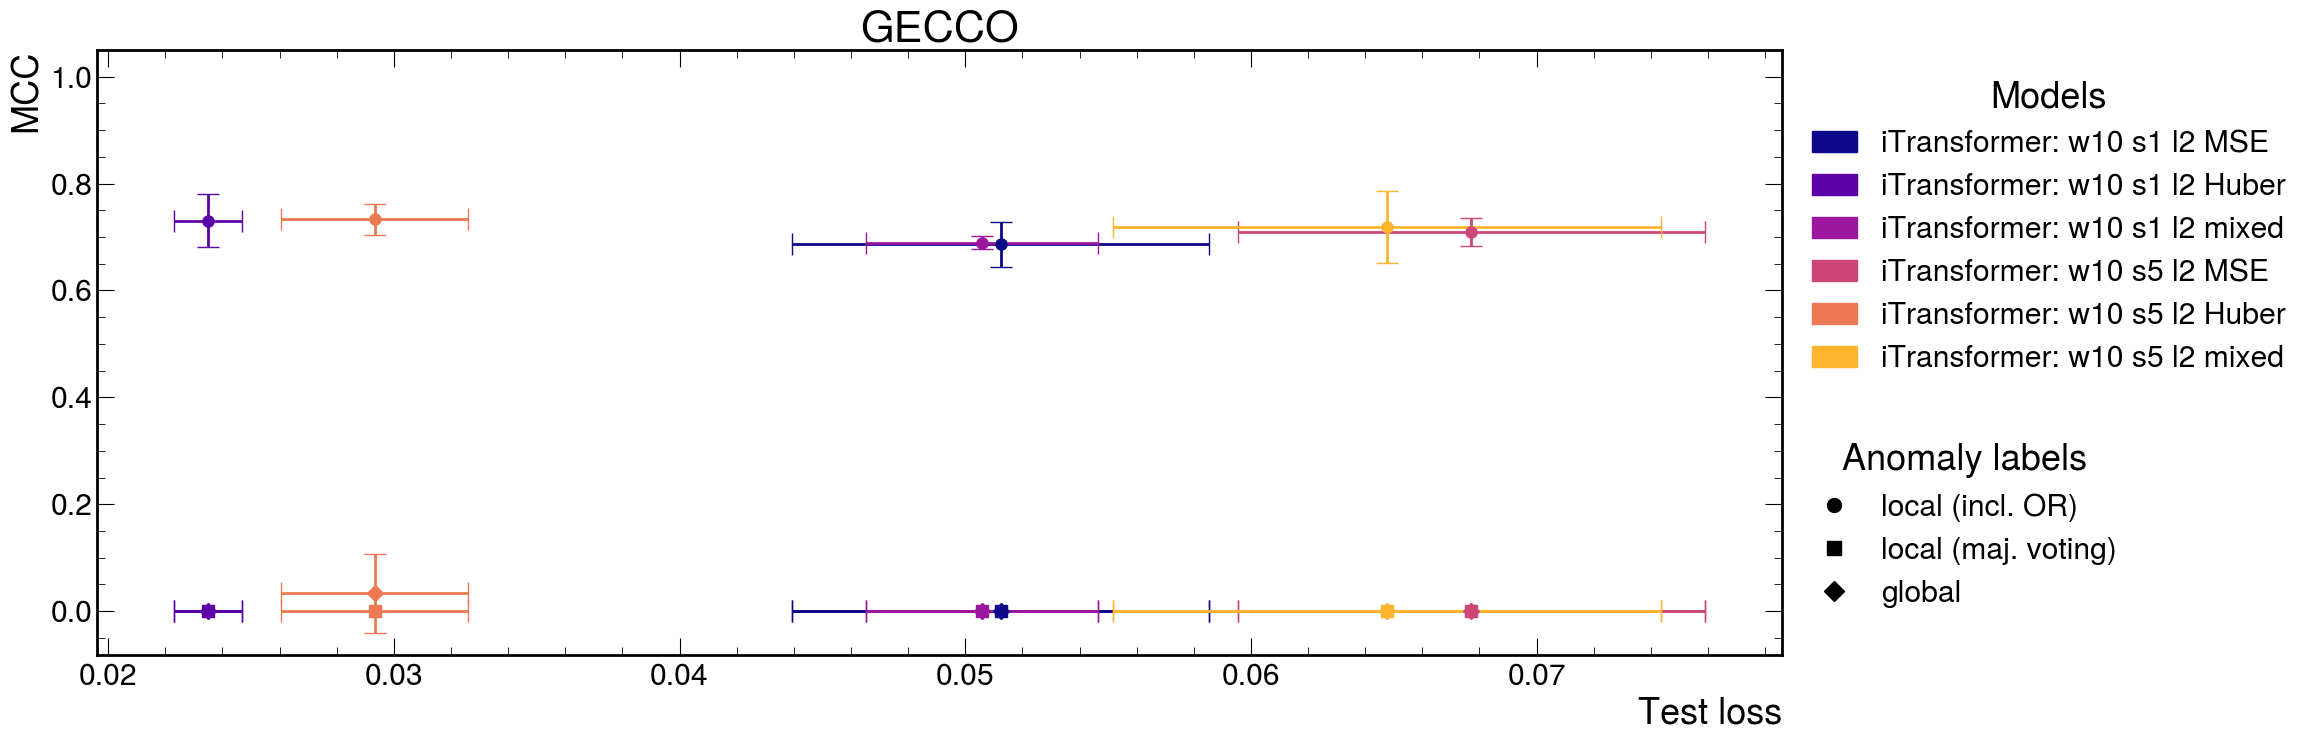

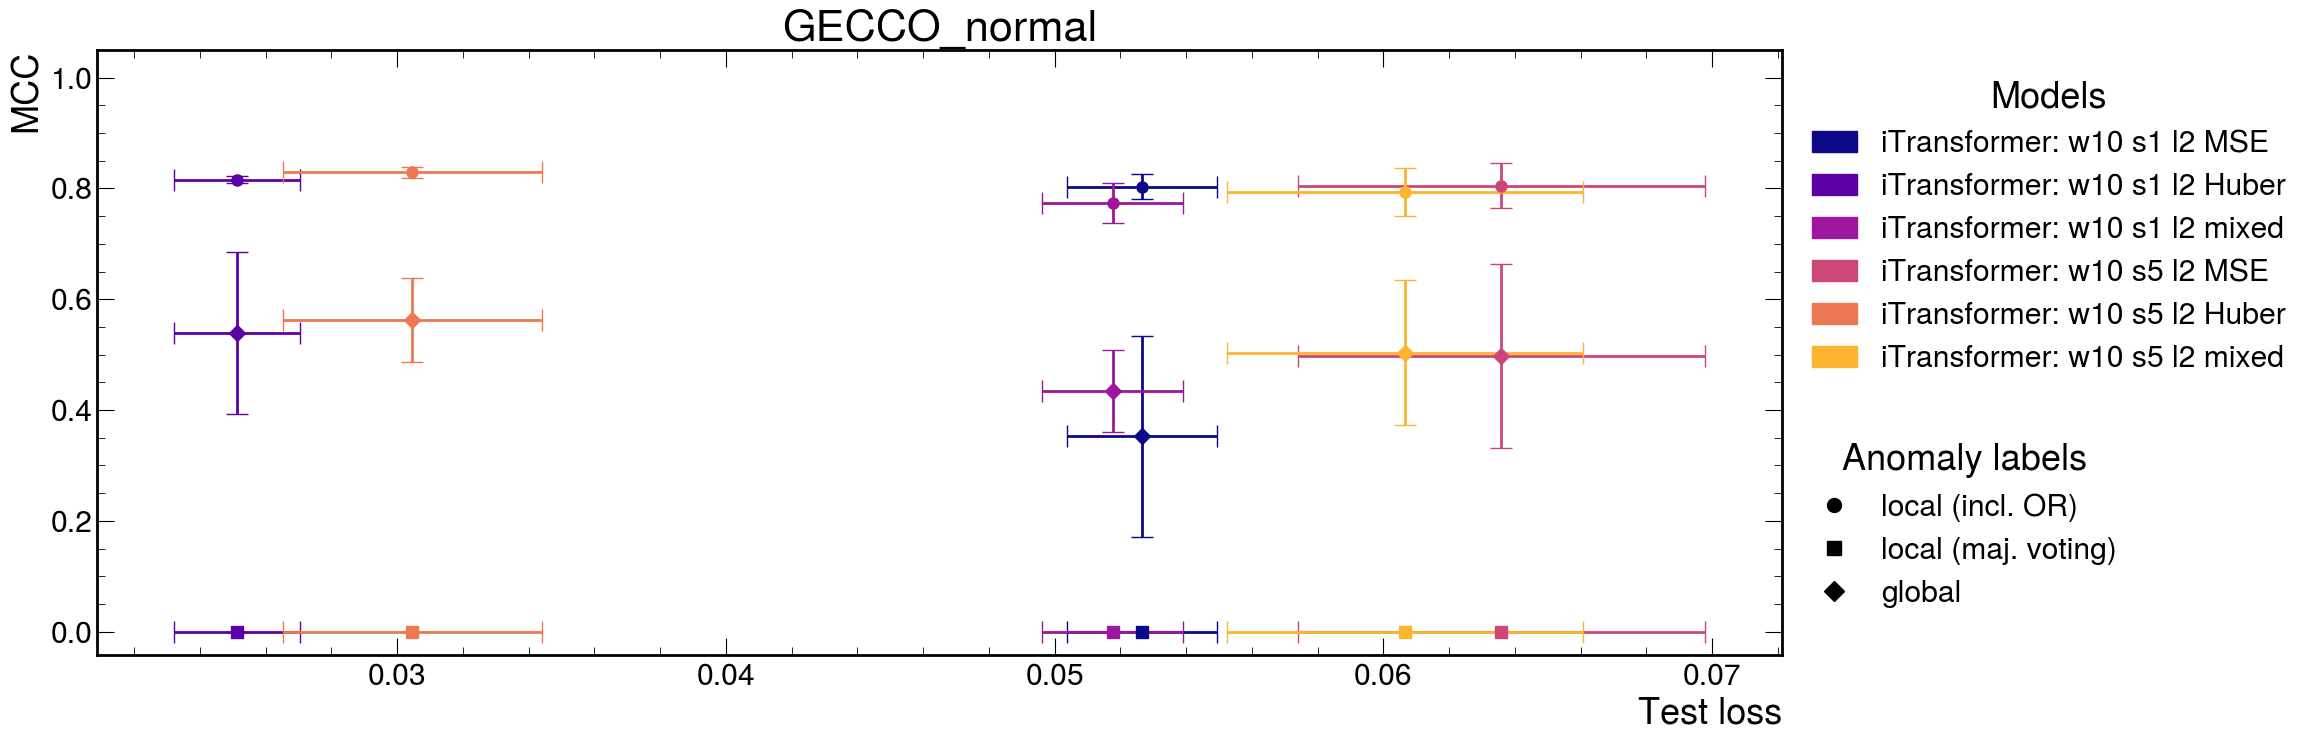

In [53]:
data_plot = ['GECCO', 'GECCO_normal'] 
models_plot = ['iTransformer1', 'iTransformer11', 'iTransformer12', 'iTransformer3', 'iTransformer31', 'iTransformer32'] 
# ['iTransformer2', 'iTransformer21',  'iTransformer22', 'iTransformer4', 'iTransformer41', 'iTransformer42']
lab = [config[m]['lab'] for m in models_plot]

for dataset in data_plot:
    name = dataset
    plot_scores2D(results_mean_std, modes, [dataset], models_plot, metric='MCC', name=None, labels=lab)

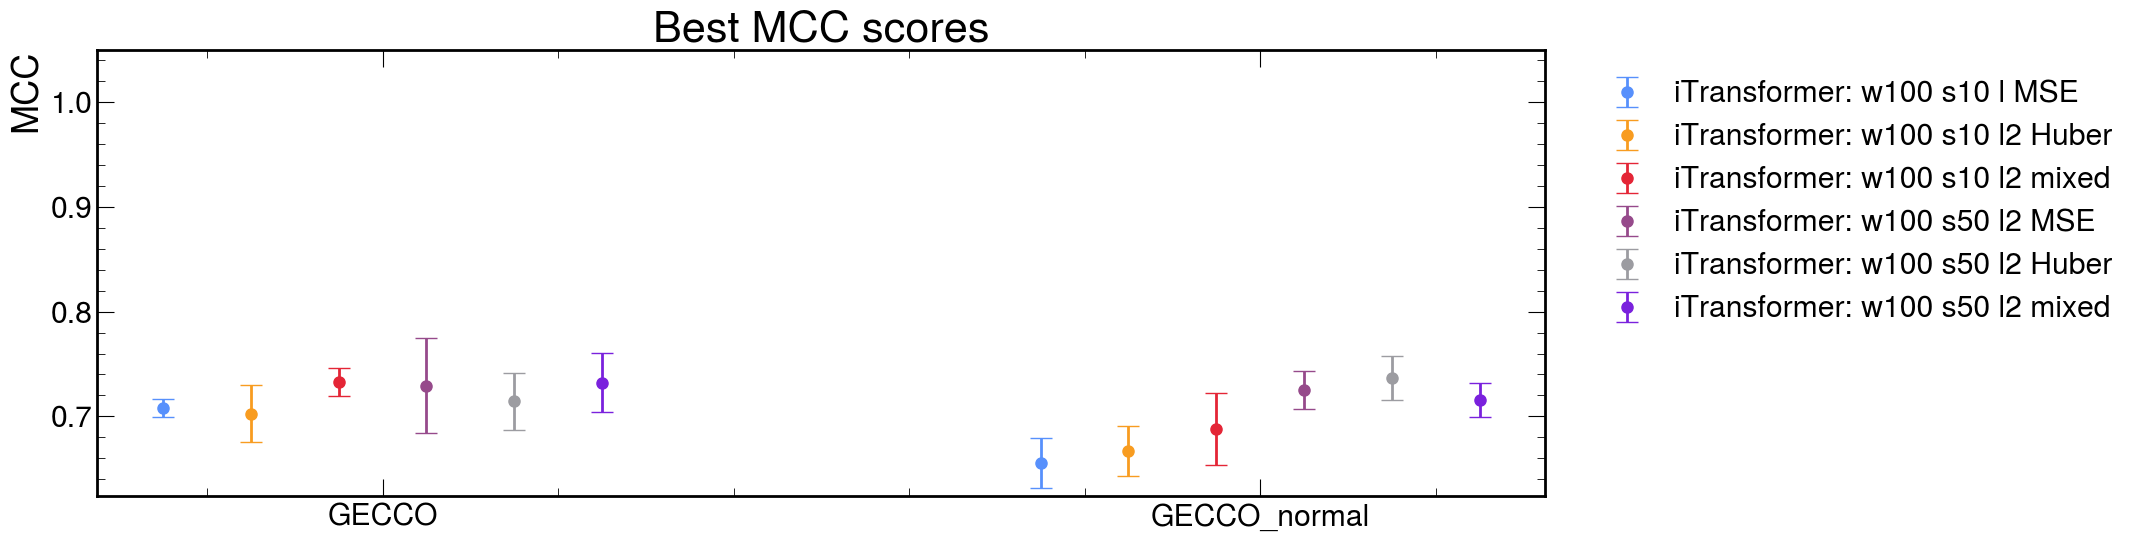

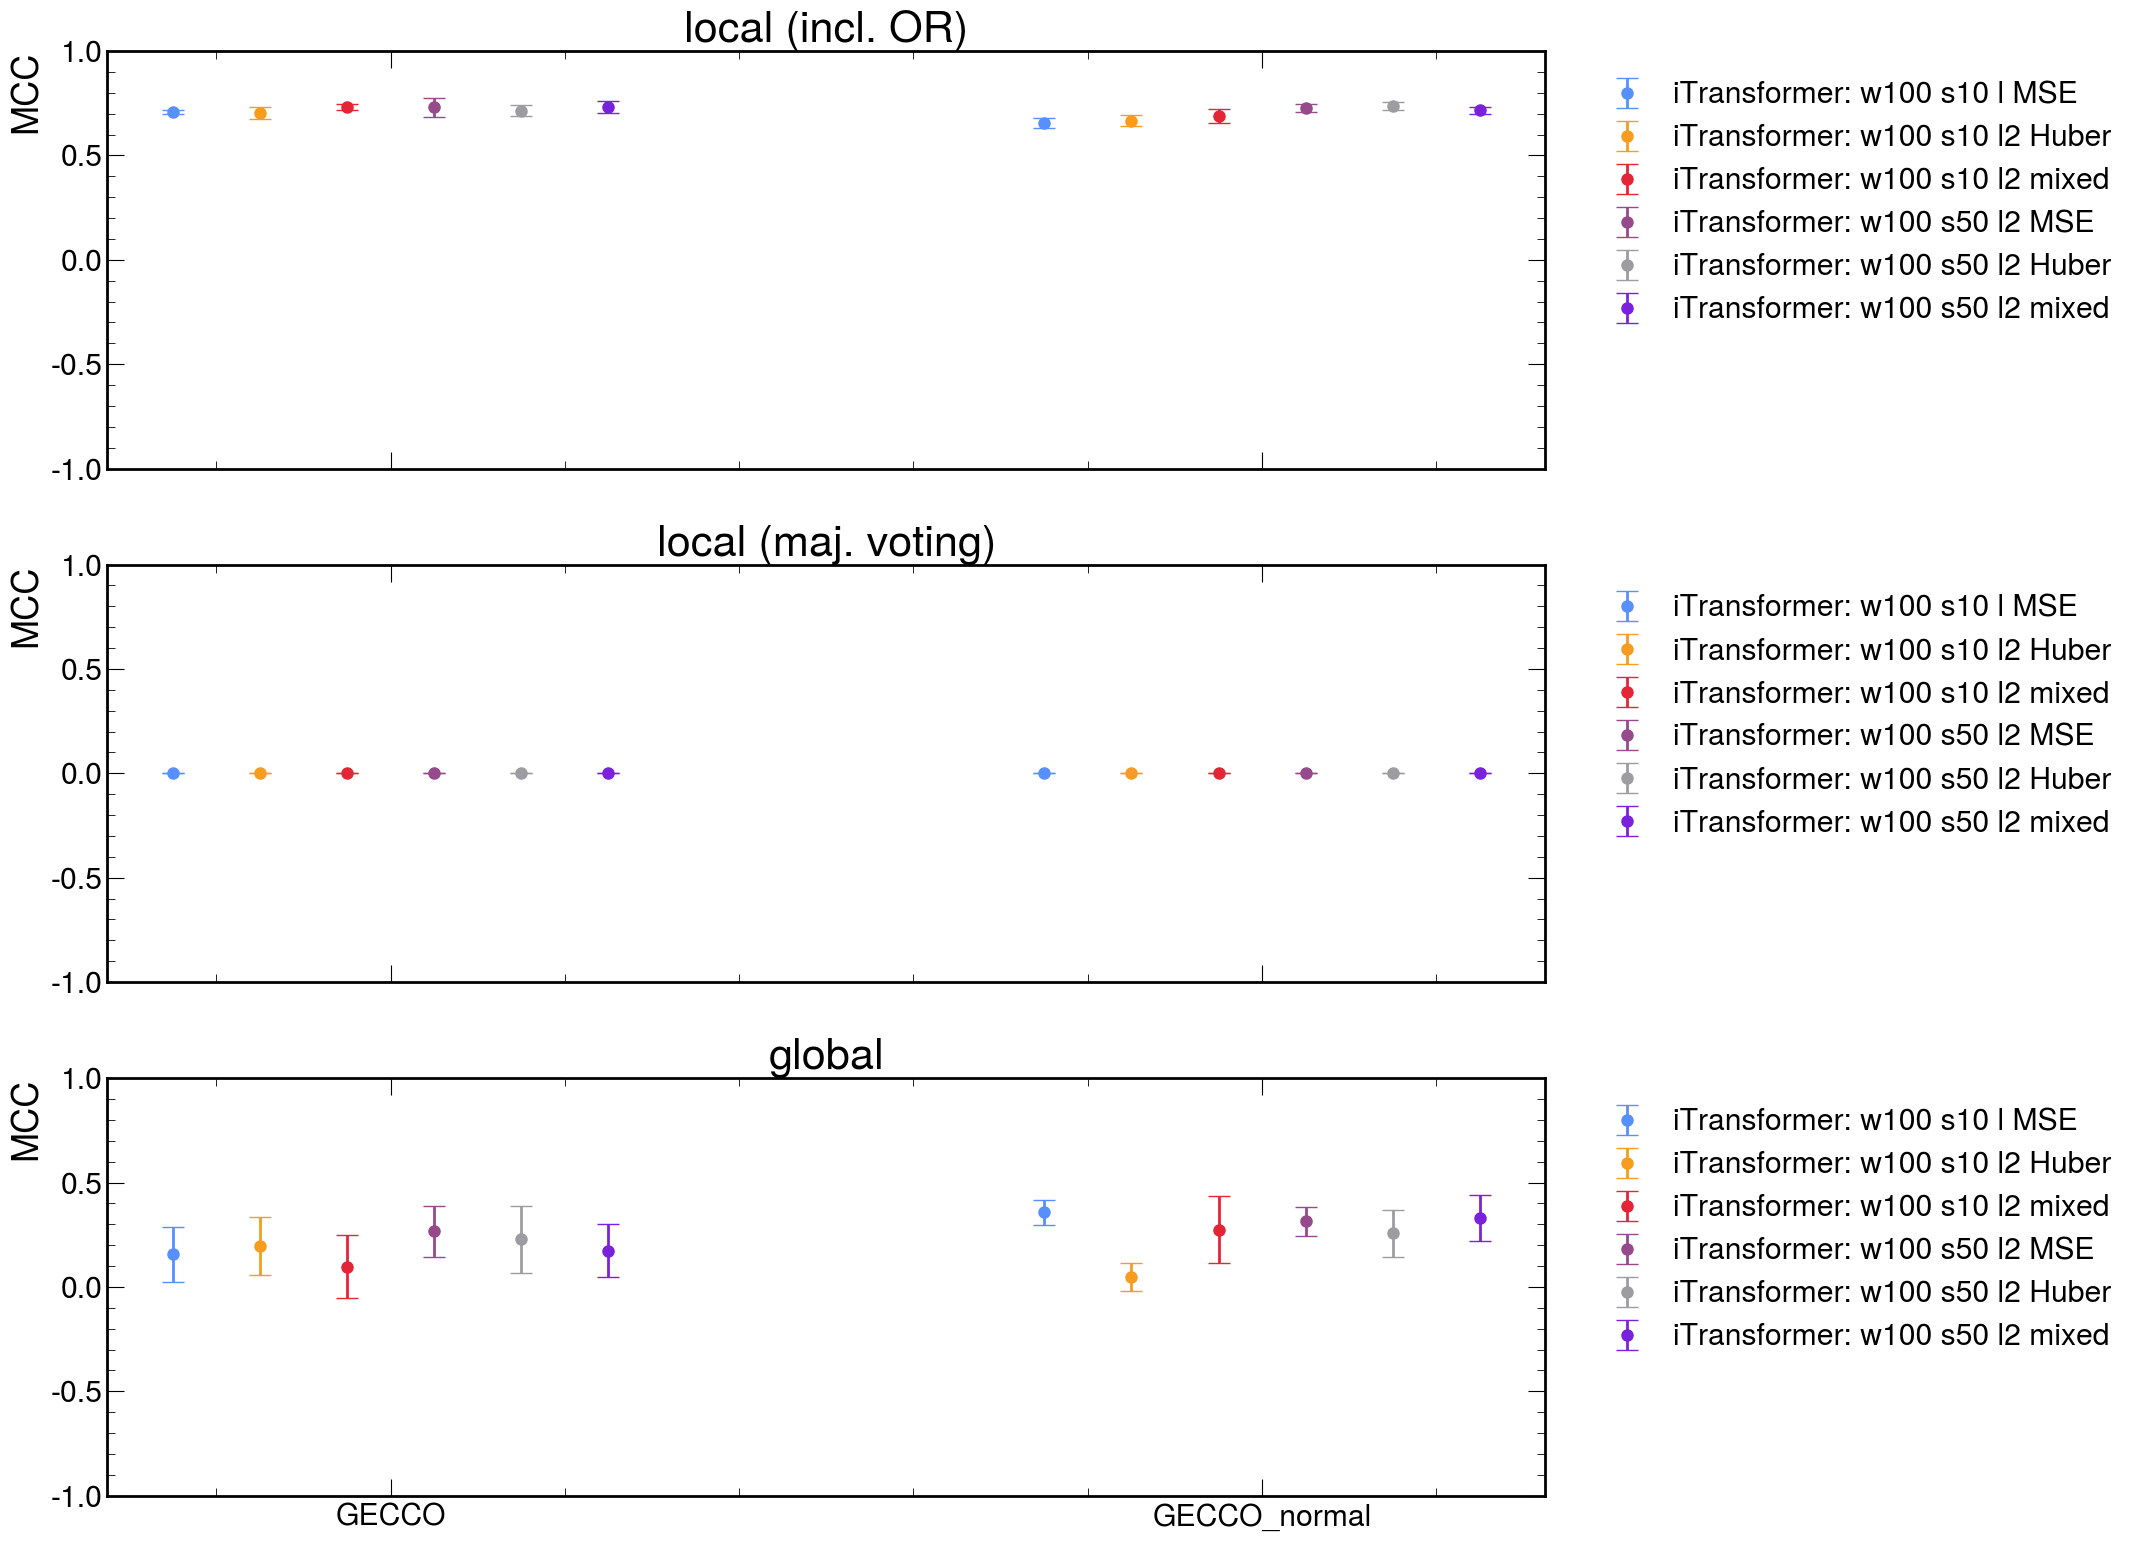

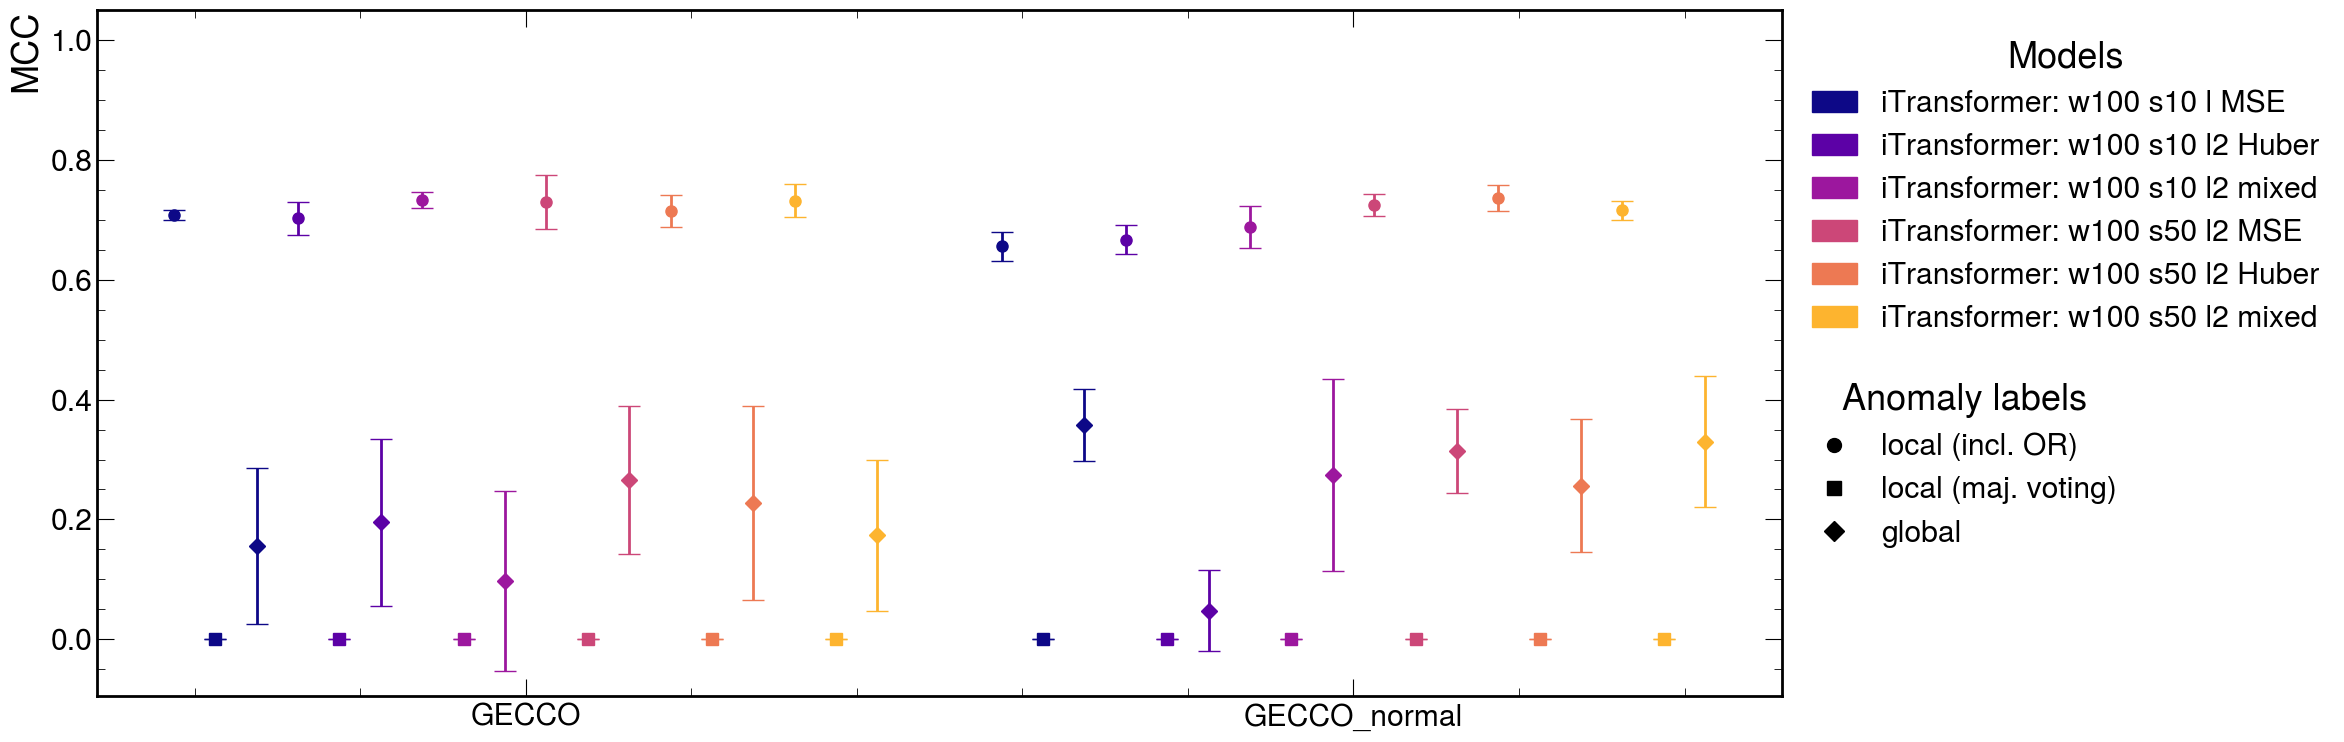

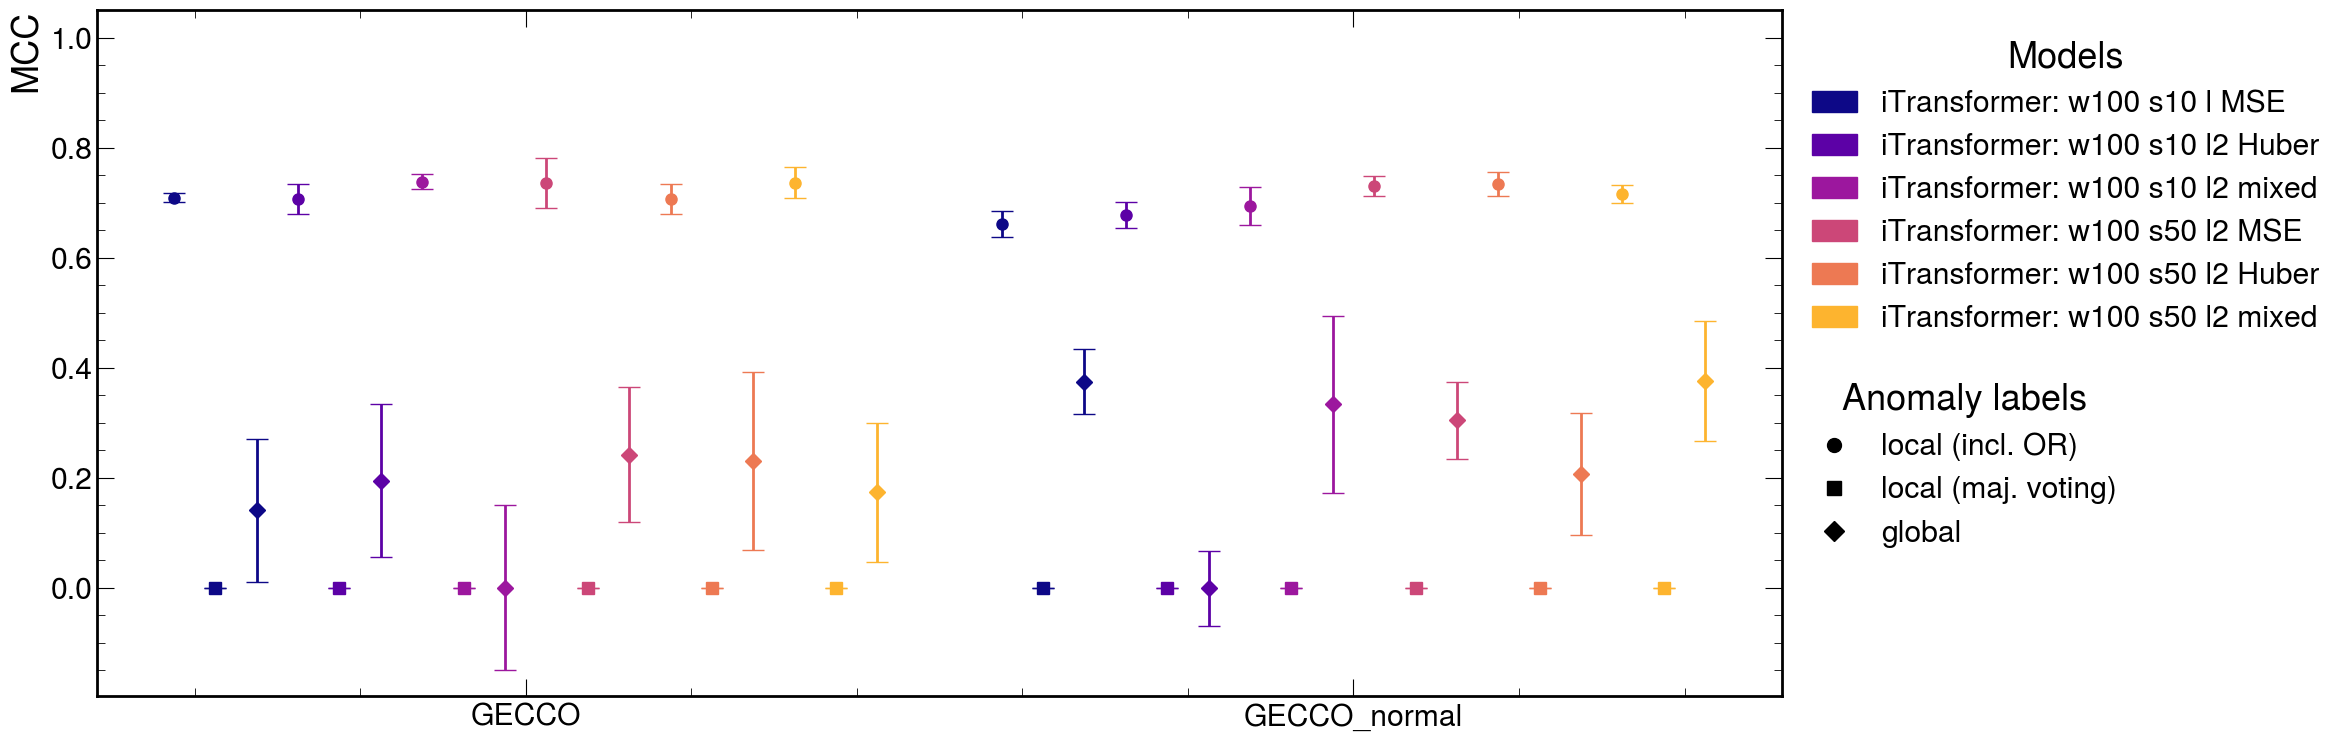

In [55]:
data_plot = ['GECCO', 'GECCO_normal'] 
models_plot = ['iTransformer4', 'iTransformer41', 'iTransformer42', 'iTransformer2', 'iTransformer21',  'iTransformer22']
# ['iTransformer4', 'iTransformer41', 'iTransformer42', 'iTransformer2', 'iTransformer21',  'iTransformer22']
# ['iTransformer1', 'iTransformer11', 'iTransformer12', 'iTransformer3', 'iTransformer31', 'iTransformer32'] 
lab = [config[m]['lab'] for m in models_plot]

name = None #  'GECCO'
plot_best_scores_mean_std_err(results_mean_std, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_median_std_err2(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)

In [57]:
val = 'mean'
metric = 'MCC'
namee = 'Huber'
data3 = ['GECCO', 'GECCO_normal'] 
models3 = ['iTransformer1', 'iTransformer11', 'iTransformer12', 'iTransformer3', 'iTransformer31', 'iTransformer32', 
          'iTransformer4', 'iTransformer41', 'iTransformer42', 'iTransformer2', 'iTransformer21',  'iTransformer22', ]
lab = [config[m]['lab'] for m in models3]

df_bestMCC3 = list_results3(results_mean_std, data3, models3, metric, labels=lab)
print(df_bestMCC3)
metric = metric.replace(' ', '_')
df_bestMCC3.to_csv(f'studies_Huberloss/{metric}_{namee}_latex.csv')

                              model                 mode              GECCO  \
0       iTransformer: w10 s1 l2 MSE     local (incl. OR)  0.686 $\pm$ 0.042   
1       iTransformer: w10 s1 l2 MSE  local (maj. voting)      0.0 $\pm$ 0.0   
2       iTransformer: w10 s1 l2 MSE               global     -0.0 $\pm$ 0.0   
3     iTransformer: w10 s1 l2 Huber     local (incl. OR)  0.731 $\pm$ 0.049   
4     iTransformer: w10 s1 l2 Huber  local (maj. voting)      0.0 $\pm$ 0.0   
5     iTransformer: w10 s1 l2 Huber               global      0.0 $\pm$ 0.0   
6     iTransformer: w10 s1 l2 mixed     local (incl. OR)   0.69 $\pm$ 0.012   
7     iTransformer: w10 s1 l2 mixed  local (maj. voting)      0.0 $\pm$ 0.0   
8     iTransformer: w10 s1 l2 mixed               global      0.0 $\pm$ 0.0   
9       iTransformer: w10 s5 l2 MSE     local (incl. OR)  0.709 $\pm$ 0.026   
10      iTransformer: w10 s5 l2 MSE  local (maj. voting)      0.0 $\pm$ 0.0   
11      iTransformer: w10 s5 l2 MSE               gl

## 2D plots

In [ ]:
def get_data(datasets, models):
    data = {f'{dataset}_{model}': {} for dataset in datasets for model in models for i in range(1, 6)}

    for dataset in datasets:
        for model in models:
            print(dataset, model)
            for i in range(1, 6):
                if 'iTransformer' in model:
                    if 'forecasting' in config[model].keys():
                        datapath = glob.glob(f'iTransformer_results_lxplus_forecasting/iTransformer_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_forecasting_{i}/results/res.csv')
                    else:
                        datapath = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_{i}/results/res.csv')
                else:
                    datapath = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_{i}/results/res.csv')
                # print(len(datapath), datapath)
                

                if len(datapath) >= 1:
                    path = datapath[0]
                    res = pd.read_csv(path, index_col=0)
                    res = res.iloc[-3:]
                    modes = list(res.index)
                    for mode in modes:
                        if i == 1:
                            data[f'{dataset}_{model}'][mode] = pd.DataFrame(res.loc[mode]).T
                        else:
                            data[f'{dataset}_{model}'][mode] = pd.concat([data[f'{dataset}_{model}'][mode], pd.DataFrame(res.loc[mode]).T], axis=0)
                
                else:
                    print(f'no results found for {model} on {dataset}')
                    continue
                for mode in modes:
                    data[f'{dataset}_{model}'][mode] = data[f'{dataset}_{model}'][mode].reset_index(drop=True) 
                # print(data[f'{dataset}_{model}']['local_all'])

    return data

In [ ]:
def plot_scores2D_all(results, modes, datasets, models, metric='MCC', name=None, labels=None):

    num_subplots = math.ceil(len(datasets) / 3) # Calculate the number of subplots needed
    if num_subplots <= 3:
        fig, axs = plt.subplots(num_subplots, 3, figsize=(24, 8 * num_subplots), sharey=True, sharex=False, constrained_layout=True)
    else:
        fig, axs = plt.subplots(num_subplots, 3, figsize=(24, 8 * num_subplots), sharey=True, sharex=False)
    axs = axs.flatten()
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    for k, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            key = f'{dataset}_{model}'
            key_modes = list(results[key].keys())
            for i, mode in enumerate(modes):
                scores = np.empty(0) 
                mse = np.empty(0)

                if key in results:
                    test = results[key][key_modes[i]][metric]
                    scores = np.append(scores, test)
                    mse = np.append(mse, results[key]['global']['test_loss'])  # because they all have the same test loss
                else:
                    scores = np.append(scores, 0)
                    mse = np.append(mse, 0)

                if labels:
                    axs[k].scatter(mse, scores, marker=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
                else:
                    axs[k].scatter(mse, scores, marker=markers[i], label=f'{model} ({mode})', color=colors[j])

    for k in range(len(datasets)):
        if metric == 'MCC':
            axs[k].set_ylim(top=1.05)
            # axs[k].set_ylim(-0.2, 1.05)
        else:
            axs[k].set_ylim(top=1.0)
        if metric == 'ROC/AUC':
            axs[k].set_ylabel('ROC AUC')
        elif metric == 'f1':
            axs[k].set_ylabel('F1')
        else:
            axs[k].set_ylabel(metric)
        # axs[k].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

        # Create legend handles for colors
        color_handles = [
            mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
        ]

        # Create legend handles for marker shapes
        shape_handles = [
            mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
            mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
            mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
        ]

        axs[k].set_xlabel('Test MSE')
        axs[k].set_title(datasets[k])
        axs[k].set_xlim(0)

    if len(datasets) == 3*num_subplots - 2:
        fig.delaxes(axs[-2])
        fig.delaxes(axs[-1])
        # Add separate legends to the figure
        fig.legend(handles=color_handles, title='Models', bbox_to_anchor=(0.4, 0.3), loc='upper left')
        fig.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.75, 0.3), loc='upper left')
    elif len(datasets) == 3*num_subplots - 1:
        fig.delaxes(axs[-1])
        # Add separate legends to the figure
        # fig.legend(handles=color_handles, title='Models', bbox_to_anchor=(0.7, 0.5), loc='upper left')
        # fig.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.2), loc='upper left')
        fig.legend(handles=color_handles, title='Models', bbox_to_anchor=(0.7, 1.0), loc='upper left')
        fig.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.5), loc='upper left')
    
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/MSEvsMCC/{name}_MSEvs{metric}.png', facecolor='w')
    plt.show()


In [ ]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [ ]:
datasets = ['creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2','MSL_new', 'SMAP_new', 'SMD', 'UCR', 'SWaT_1D']  
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4', 'iTransformer5', 'iTransformer6', 'TranAD']

data = get_data(datasets, models)
# print(data['GECCO_iTransformer1'].keys())
print(data['GECCO_iTransformer1']['global']['MCC'])


In [ ]:
datasets = ['creditcard_normal', 'IEEECIS_new2.2']  # ['GECCO', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD'] #, 'UCR', 'SWaT_1D']
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4', 'iTransformer5', 'iTransformer6', 'TranAD']
lab = [config[m]['lab'] for m in models]

plot_scores2D_all(data, modes, datasets, models, 'MCC', None, lab)

## combine 5 models for 1 common test

In [ ]:
from main import backprop, local_pot, local_anomaly_labels
from src.data_loader import MyDataset, DataLoader
from src.pot import pot_eval
from src.diagnosis import hit_att, ndcg
import math

In [ ]:
def load_model(modelname, dims, n_window, step_size=None, path=None, prob=False, weighted=False):
	import src.models
	model_class = getattr(src.models, modelname)
	if modelname == 'iTransformer':
		model = model_class(dims, n_window, step_size, prob, weighted).double()
	else:
		model = model_class(dims, n_window, prob).double()
	
	optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

	print(f"Loading pre-trained model: {model.name} from {path}")
	checkpoint = torch.load(path)
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
	epoch = checkpoint['epoch']
	accuracy_list = checkpoint['accuracy_list']

	return model, optimizer, scheduler, epoch, accuracy_list

In [ ]:
def combine_scores(dataset, model, modeltype, approach=1):
    if modeltype == 'iTransformer':
        if 'forecasting' in config[model].keys():
            checkpoints_path = glob.glob(f'{modeltype}_results_lxplus_forecasting/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_forecasting*/checkpoints/model_best.ckpt')
        else:
            checkpoints_path = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_*/checkpoints/model_best.ckpt')
    else:
        checkpoints_path = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_*/checkpoints/model_best.ckpt')
    # checkpoints_path = sorted(checkpoints_path, key=lambda x: int(x.split('_latent')[-1].split('_')[0]))
    print(checkpoints_path)
    print(len(checkpoints_path))
    if len(checkpoints_path) == 0:
        print(f'No checkpoints found for {model} on {dataset}')
        return
    res_path = os.path.join(checkpoints_path[0].split('/')[0], checkpoints_path[0].split('/')[1], f'results_combined{approach}', checkpoints_path[0].split('/')[2][:-2])
    print(res_path)
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    flag_less = False
    feats = -1
    if dataset == 'IEEECIS_new2.2':
        feats = 30
    elif dataset in ['SMAP_new', 'SMD', 'MSL_new']:
        flag_less = True

    test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='test', feats=feats, enc=False, less=flag_less, k=-1)
    train_test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='train', feats=feats, less=flag_less, enc=False, k=-1)
    feats = test.feats
    enc_feats = test.enc_feats
    labels = test.get_labels()

    train_MSE, test_MSE = np.empty(0), np.empty(0)
    train_pred, test_pred = np.empty(0), np.empty(0)
    for j, path in enumerate(checkpoints_path):
        print(f'validation fold {j}')
        trained_model, optimizer, scheduler, epoch, accuracy_list = load_model(modeltype, feats, config[model]['window'], config[model]['steps'], path, prob=False, weighted=False)
        trained_model.eval()
        print(f'Loaded model from training {j}')

        # if os.path.exists(f'{res_path}/res_combined.csv') and os.path.exists(f'{res_path}/pred_labels_combined.csv'):
        #     print(f'{model} already evaluated')
        #     return

        data_loader_train_test = DataLoader(train_test, batch_size=trained_model.batch, shuffle=False)
        data_loader_test = DataLoader(test, batch_size=trained_model.batch, shuffle=False)
        
        if approach == 1:
            lossT = backprop(-1, trained_model, data_loader_train_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=False)  # need anomaly scores on training data for POT
        else:
            lossT, yT_pred = backprop(-1, trained_model, data_loader_train_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)  # need anomaly scores on training data for POT
        loss, y_pred = backprop(-1, trained_model, data_loader_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)

        if 'iTransformer' in trained_model.name or trained_model.name in ['LSTM_AE']:
            # cut out the padding from test data, loss tensors
            lossT_tmp, loss_tmp, y_pred_tmp, yT_pred_tmp = [], [], [], []
            # print(test.get_ts_lengths(), np.sum(test.get_ts_lengths()), len(test.get_ts_lengths()))
            # print(test.get_ideal_lengths(), np.sum(test.get_ideal_lengths()), len(test.get_ideal_lengths()))
            start = 0
            for i, l in enumerate(test.get_ts_lengths()):
                loss_tmp.append(loss[start:start+l])
                y_pred_tmp.append(y_pred[start:start+l])
                start += test.get_ideal_lengths()[i]
            
            start = 0
            for i, l in enumerate(train_test.get_ts_lengths()):
                lossT_tmp.append(lossT[start:start+l])
                if approach == 2:
                    yT_pred_tmp.append(yT_pred[start:start+l])
                start += train_test.get_ideal_lengths()[i]

            lossT = np.concatenate(lossT_tmp, axis=0)
            loss = np.concatenate(loss_tmp, axis=0)
            y_pred = np.concatenate(y_pred_tmp, axis=0)
            if approach == 2:
                yT_pred = np.concatenate(yT_pred_tmp, axis=0)
        train_loss = np.mean(lossT)
        test_loss = np.mean(loss)

        if approach == 1:
            # first approach, average loss over all models
            if j == 0:
                train_MSE = lossT
                test_MSE = loss
            else:
                train_MSE += lossT
                test_MSE += loss
            print(train_MSE.shape, test_MSE.shape)

        elif approach == 2:
            # second approach, combine reconstructions and THEN compute reco loss
            if j == 0:
                train_pred = yT_pred
                test_pred = y_pred
            else:
                train_pred += yT_pred
                test_pred += y_pred
            print(train_pred.shape, test_pred.shape)

    if approach == 1:
        train_MSE /= len(checkpoints_path)
        test_MSE /= len(checkpoints_path)
        print(train_MSE.shape, test_MSE.shape)
        lossT = train_MSE
        loss = test_MSE

    elif approach == 2:
        train_pred /= len(checkpoints_path)
        test_pred /= len(checkpoints_path)
        train_true = train_test.get_complete_data()
        test_true = test.get_complete_data()
        train_MSE2 = np.abs(train_pred - train_true)
        test_MSE2 = np.abs(test_pred - test_true)
        lossT = train_MSE2
        loss = test_MSE2
    
    ### anomaly labels
    preds, _ = local_pot(loss, lossT, labels)
    true_labels = (np.sum(labels, axis=1) >= 1) + 0
    # local anomaly labels
    labelspred, result_local1 = local_anomaly_labels(preds, true_labels, nb_adim=1)
    majority = math.ceil(labels.shape[1] / 2)  # do majority voting over dimensions for local results instead of inclusive OR
    labelspred_maj, result_local2 = local_anomaly_labels(preds, true_labels, nb_adim=majority)

    # global anomaly labels
    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    true_labels = (np.sum(labels, axis=1) >= 1) + 0
    result_global, pred2 = pot_eval(lossTfinal, lossFinal, true_labels, None, f'all_dim')
    labelspred_glob = (pred2 >= 1) + 0
    result_global.update(hit_att(loss, labels))
    result_global.update(ndcg(loss, labels))
    result_global.update({'detection_level_q': 1e-5})
    result_global.update({'train_loss': train_loss, 'test_loss': test_loss})
    print('\nglobal results') 
    print(result_global)

    # saving results
    df_res_global = pd.DataFrame.from_dict(result_global, orient='index').T
    df_res_global.index = ['global']
    result_local1 = pd.DataFrame.from_dict(result_local1, orient='index').T
    result_local2 = pd.DataFrame.from_dict(result_local2, orient='index').T
    result_local1.index = ['local_all']
    result_local2.index = ['local_all_maj']
    df_res_local = pd.concat([result_local1, result_local2])
    df_res = pd.concat([df_res_local, df_res_global]) 
    df_labels = pd.DataFrame({'local': labelspred, 'local_maj': labelspred_maj, 'global': labelspred_glob})

    df_res.to_csv(f'{res_path}/res_combined.csv')    
    df_labels.to_csv(f'{res_path}/pred_labels_combined.csv', index=False)


In [ ]:
# modeltype = 'iTransformer'
# datasets = ['creditcard_normal']  # 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SWaT_1D', 'UCR'
# models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2'] #, 'TranAD'] # , 'iTransformer5', 'iTransformer6']

# for dataset in datasets:
#     for model in models:
#         combine_scores(dataset, model, modeltype, approach=1)

In [ ]:
for approach in [1, 2]:

    modeltype = 'iTransformer'
    datasets = ['creditcard_normal']  # 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SWaT_1D', 'UCR'
    models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2'] #, 'TranAD'] # , 'iTransformer5', 'iTransformer6']

    for dataset in datasets:
        for model in models:
            combine_scores(dataset, model, modeltype, approach=approach)

    modeltype = 'TranAD'
    models = ['TranAD']

    for dataset in datasets:
        for model in models:
            combine_scores(dataset, model, modeltype, approach=approach)


In [ ]:
def plot_scores(results, datasets, models, modes, metric='MCC', name=None, labels=None):
    fig, ax = plt.subplots(figsize=(28, 8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if key in results:
                    scores = np.append(scores, results[key][metric].iloc[i])
                else:
                    scores = np.append(scores, 0)
            
            x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
            if labels:
                ax.scatter(x_positions, scores, label=f'{labels[j]} ({mode})', marker=markers[i], color=colors[j])  
            else:
                ax.scatter(x_positions, scores, label=f'{model} ({mode})', marker=markers[i], color=colors[j]) 
                
    ax.set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets, rotation=15)
    # ax.set_ylim(top=1.0)
    if metric == 'ROC/AUC':
        ax.set_ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        ax.set_ylabel('F1')
    else:
        ax.set_ylabel(metric)    

    # Create legend handles for colors
    color_handles = [
        mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
    ]

    # Create legend handles for marker shapes
    shape_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
        mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
    ]

    # Add separate legends to the plot
    legend1 = ax.legend(handles=color_handles, title='Models', bbox_to_anchor=(1.0, 1), loc='upper left')
    legend2 = ax.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(1.0, 0.4), loc='upper left')

    # Add the first legend back to the plot to ensure it shows up
    ax.add_artist(legend1)
    # fig.subplots_adjust(right=0.8)
    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_results_lxplus/combined_models{name}_{metric}.png', facecolor='w')
    plt.show()


In [ ]:
%matplotlib inline

In [ ]:
approach = 1 # 2

In [ ]:
datasets = ['creditcard_normal', 'IEEECIS_new2.2']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SMAP_new', 'SWaT_1D', 'UCR']  # 
models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  #  'iTransformer5', 'iTransformer6',

data = {f'{model}_{dataset}': [] for dataset in datasets for model in models}

for dataset in datasets:
    for model in models:
        if 'iTransformer' in model:
            modeltype = 'iTransformer'
            path = glob.glob(f"{modeltype}_results_lxplus/{modeltype}_{dataset}/results_combined{approach}/n_window{config[model]['window']}_steps{config[model]['steps']}_feats*_eps{config[model]['eps']}_latent{config[model]['latent']}*/res_combined.csv")
        elif 'TranAD' in model:
            modeltype = 'TranAD'
            path = glob.glob(f"{modeltype}_results_lxplus/{modeltype}_{dataset}/results_combined{approach}/n_window{config[model]['window']}_steps{config[model]['steps']}_feats*_eps{config[model]['eps']}*/res_combined.csv")
        if path:
            path = path[0]
        else:
            print(f'No combined results found for {model} on {dataset}')
            continue
        res = pd.read_csv(path, index_col=0)
        data[f'{model}_{dataset}'] = res

print(data.keys())
# print(data['iTransformer1_GECCO'])

In [ ]:
%matplotlib inline
datasets = ['creditcard_normal', 'IEEECIS_new2.2']  # ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SMAP_new', 'SWaT_1D', 'UCR'] 
models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  #  'iTransformer5', 'iTransformer6',

lab = [config[m]['lab'] for m in models]

plot_scores(data, datasets, models, modes, metric='MCC', name=f'fraud_approach{approach}', labels=lab)


In [ ]:
def list_results(results, datasets, models, metric='MCC', labels=None):

    df = pd.DataFrame()
    rows = []
    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            rows = pd.Series([rf'{results[f"{model}_{dataset}"][metric].iloc[i].round(3)}' if f"{model}_{dataset}" in results else 0 for dataset in datasets], index=datasets)
            complete_row = pd.Series({'model': labels[j], 'mode': mode})
            complete_row = pd.concat([complete_row, rows])
            df = pd.concat([df, pd.DataFrame(complete_row).T], ignore_index=True)
    
    # print(df)
    return df


In [ ]:
val = 'mean'
metric = 'MCC'
namee = f'combined_res_approach{approach}'
data3 = ['IEEECIS_new2.2', 'GECCO', 'GECCO_normal', 'MSL_new','SMAP_new', 'SMD', 'SWaT_1D', 'UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR']
models3 = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  # 'iTransformer5', 'iTransformer6',

lab = [config[m]['lab'] for m in models3]

# dict_bestMCC = list_results(results_mean_std, data3, models3, metric, labels=lab, val=val)
# df_bestMCC2 = list_results2(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC3 = list_results(data, data3, models3, metric, labels=lab)
# df_bestMCC = pd.DataFrame(dict_bestMCC, index=data3).T
print(df_bestMCC3)
# print(df_bestMCC2)
metric = metric.replace(' ', '_')
# df_bestMCC.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
# df_bestMCC2.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
df_bestMCC3.to_csv(f'studies_results_lxplus/{metric}_{namee}_all.csv')
# df_bestMCC2.to_csv(f'studies_datasets/{metric}_{namee}_{val}.csv')
# df_bestMCC3.to_csv(f'studies_datasets/{metric}_{namee}_all_latex.csv')

## visualise train / test variance

In [ ]:
def get_MSEmean_std(dataset, model, modeltype):
    if modeltype == 'iTransformer':
        if 'forecasting' in config[model].keys():
            checkpoints_path = glob.glob(f'{modeltype}_results_lxplus_forecasting/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_forecasting*/checkpoints/model_epoch20.ckpt')
        else:
            # checkpoints_path = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_*/checkpoints/model_epoch4.ckpt')
            checkpoints_path = glob.glob(f'{modeltype}/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_Huber*/checkpoints/model_epoch4.ckpt')
            # checkpoints_path = [p for p in checkpoints_path if 'Huber' not in p and 'shuffle' not in p]
    else:
        checkpoints_path = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_*/checkpoints/model_best.ckpt')
    # checkpoints_path = sorted(checkpoints_path, key=lambda x: int(x.split('_latent')[-1].split('_')[0]))
    print(checkpoints_path)
    print(len(checkpoints_path))
    if len(checkpoints_path) == 0:
        print(f'No checkpoints found for {model} on {dataset}')
        return
    # res_path = os.path.join(checkpoints_path[0].split('/')[0], checkpoints_path[0].split('/')[1], f'results_combined{}', checkpoints_path[0].split('/')[2][:-2])
    # print(res_path)
    # if not os.path.exists(res_path):
        # os.makedirs(res_path)

    flag_less = False
    feats = -1
    if dataset == 'IEEECIS_new2.2':
        feats = 30
    elif dataset in ['SMAP_new', 'SMD', 'MSL_new']:
        flag_less = True

    test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='test', feats=feats, enc=False, less=flag_less, k=-1)
    train_test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='train', feats=feats, less=flag_less, enc=False, k=-1)
    feats = test.feats
    enc_feats = test.enc_feats
    labels = test.get_labels()

    for j, path in enumerate(checkpoints_path):
        print(f'validation fold {j}')
        trained_model, optimizer, scheduler, epoch, accuracy_list = load_model(modeltype, feats, config[model]['window'], config[model]['steps'], path, prob=False, weighted=False)
        trained_model.eval()
        print(f'Loaded model from training {j}')

        # if os.path.exists(f'{res_path}/res_combined.csv') and os.path.exists(f'{res_path}/pred_labels_combined.csv'):
        #     print(f'{model} already evaluated')
        #     return

        data_loader_train_test = DataLoader(train_test, batch_size=trained_model.batch, shuffle=False)
        data_loader_test = DataLoader(test, batch_size=trained_model.batch, shuffle=False)
        
        lossT, yT_pred = backprop(-1, trained_model, data_loader_train_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)  # need anomaly scores on training data for POT
        loss, y_pred = backprop(-1, trained_model, data_loader_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)

        if 'iTransformer' in trained_model.name or trained_model.name in ['LSTM_AE']:
            # cut out the padding from test data, loss tensors
            lossT_tmp, loss_tmp, y_pred_tmp, yT_pred_tmp = [], [], [], []
            # print(test.get_ts_lengths(), np.sum(test.get_ts_lengths()), len(test.get_ts_lengths()))
            # print(test.get_ideal_lengths(), np.sum(test.get_ideal_lengths()), len(test.get_ideal_lengths()))
            start = 0
            for i, l in enumerate(test.get_ts_lengths()):
                loss_tmp.append(loss[start:start+l])
                y_pred_tmp.append(y_pred[start:start+l])
                start += test.get_ideal_lengths()[i]
            
            start = 0
            for i, l in enumerate(train_test.get_ts_lengths()):
                lossT_tmp.append(lossT[start:start+l])
                yT_pred_tmp.append(yT_pred[start:start+l])
                start += train_test.get_ideal_lengths()[i]

            lossT = np.concatenate(lossT_tmp, axis=0)
            loss = np.concatenate(loss_tmp, axis=0)
            y_pred = np.concatenate(y_pred_tmp, axis=0)
            yT_pred = np.concatenate(yT_pred_tmp, axis=0)
        train_loss = np.mean(lossT)
        test_loss = np.mean(loss)
        train_var = np.var(lossT)
        test_var = np.var(loss)

        lossT2 = yT_pred - train_test.get_complete_data()
        loss2 = y_pred - test.get_complete_data()

        fig, axes = plt.subplots(1, lossT2.shape[1], figsize=(25, 6), sharex=True, sharey=True, constrained_layout=True)
        for i in range(lossT2.shape[1]):
            axes[i].hist(lossT2[:, i], bins=20, label='train') #, range=(-1, 1))
            axes[i].hist(loss2[:, i], bins=20, label='test', alpha=0.7) #, range=(-1, 1))
            axes[i].axvline(x=np.mean(lossT2[:, i]), color='k', label='mean train')
            axes[i].axvline(x=np.mean(loss2[:, i]), color='r', linestyle=':', label='mean test')
            axes[i].set_yscale('log')
        axes[-1].legend()
        fig.suptitle(f'{model} on {dataset}, valid fold {j+1}')
        plt.show()
        plt.close()
        
        print(f'train mean: {train_loss}, test mean: {test_loss}, train var: {train_var}, test var: {test_var}')
        print(f'train mean: {np.mean(lossT2)}, test mean: {np.mean(loss2)}, train var: {np.var(lossT2)}, test var: {np.var(loss2)}')
        

In [ ]:
%matplotlib inline

In [ ]:
modeltype = 'iTransformer'
datasets = ['GECCO_normal']  # 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SWaT_1D', 'UCR'
models = ['iTransformer1']  #, 'iTransformer3', 'iTransformer4', 'iTransformer2'] #, 'TranAD'] # , 'iTransformer5', 'iTransformer6']

for dataset in datasets:
    for model in models:
        get_MSEmean_std(dataset, model, modeltype)

In [ ]:
modeltype = 'iTransformer'
datasets = ['GECCO_normal']  # 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SWaT_1D', 'UCR'
models = ['iTransformer1']  #, 'iTransformer3', 'iTransformer4', 'iTransformer2'] #, 'TranAD'] # , 'iTransformer5', 'iTransformer6']

for dataset in datasets:
    for model in models:
        get_MSEmean_std(dataset, model, modeltype)